<a href="https://colab.research.google.com/github/achyutak/Project-2021/blob/main/Sikka_AI/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
import zipfile
import random
import nltk
import string
nltk.download('punkt')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Extracting data to drive

In [3]:
# import glob
# for i in glob.glob("*.zip"):
#   with zipfile.ZipFile('/content/' + i , 'r') as zip_ref:
#     zip_ref.extractall('/content')


In [4]:
# cd /content/drive/MyDrive/Project-2021

In [5]:
# mkdir Sikka_AI
# # cd Sikka_AI/

In [6]:
# mv /content/sample_submission.csv ./

#Data Exploration


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Project-2021/Sikka_AI/train.csv')

In [8]:
df.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [10]:
df.id.describe()

count               159571
unique              159571
top       e4ba1b2a41a1399b
freq                     1
Name: id, dtype: object

In [11]:
df.comment_text.describe()

count                                                159571
unique                                               159571
top       I'll just wait til my IP address changes in a ...
freq                                                      1
Name: comment_text, dtype: object

In [12]:
df.toxic.describe()

count    159571.000000
mean          0.095844
std           0.294379
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64

In [13]:
df.severe_toxic.describe()

count    159571.000000
mean          0.009996
std           0.099477
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: severe_toxic, dtype: float64

In [14]:
df.obscene.describe()

count    159571.000000
mean          0.052948
std           0.223931
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: obscene, dtype: float64

In [15]:
df.threat.describe()

count    159571.000000
mean          0.002996
std           0.054650
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: threat, dtype: float64

In [16]:
df.insult.describe()

count    159571.000000
mean          0.049364
std           0.216627
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: insult, dtype: float64

In [17]:
df.identity_hate.describe()

count    159571.000000
mean          0.008805
std           0.093420
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: identity_hate, dtype: float64

In [18]:
new_df = df.copy()

In [19]:
new_df.drop(columns='id',inplace=True)

In [20]:
new_df['Number_of_categories'] = new_df['identity_hate'] + new_df['insult'] + new_df['obscene'] + new_df['severe_toxic'] + new_df['threat'] + new_df['toxic']

In [21]:
new_df.Number_of_categories.describe()

count    159571.000000
mean          0.219952
std           0.748260
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: Number_of_categories, dtype: float64

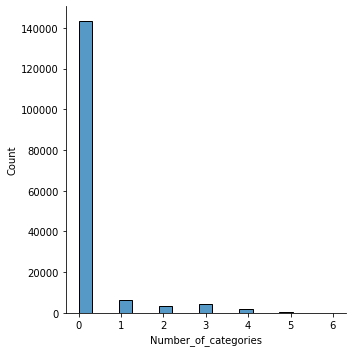

In [22]:
sns.displot(new_df.Number_of_categories)

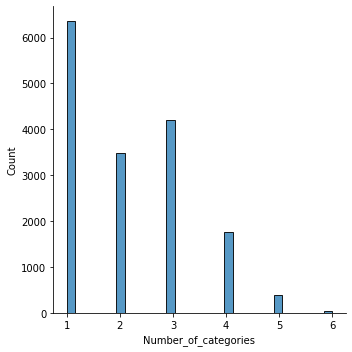

In [23]:
sns.displot(new_df.Number_of_categories[new_df['Number_of_categories'] > 0])

In [24]:
new_df[new_df.Number_of_categories == 0].index

Int64Index([     0,      1,      2,      3,      4,      5,      7,      8,
                 9,     10,
            ...
            159561, 159562, 159563, 159564, 159565, 159566, 159567, 159568,
            159569, 159570],
           dtype='int64', length=143346)

There are roughly 17000 (16225 to be precise) comments that belong to one of the 6 categories. The remaining 143346 of 159571 comments do not have any toxicity. This distribution may make the ML method biased.

##Important decision here

Since there are 16225 comments that belong to one of the 6 categories, select a number (larger or smaller or equal to 16225 in `num_of_nothing_bad`) of comments that do not belong to any of the categories to be in the training data. This eliminates the strong bias

In [25]:
num_of_nothing_bad = 20000 #replace the number here
index_list_none = random.sample(set(new_df[new_df.Number_of_categories == 0].index),num_of_nothing_bad)

In [26]:
index_list_atleast_one = new_df[new_df.Number_of_categories > 0].index

In [27]:
drop_list = []
for i in new_df.index:
  if i not in index_list_none and i not in index_list_atleast_one:
    drop_list.append(i)

In [28]:
new_df.drop(labels=drop_list,inplace=True)

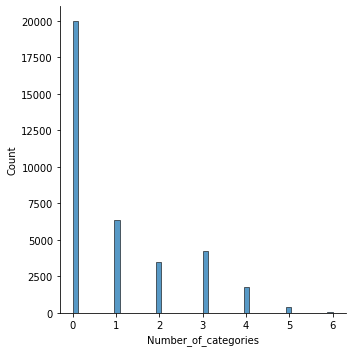

In [29]:
sns.displot(data=new_df['Number_of_categories'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


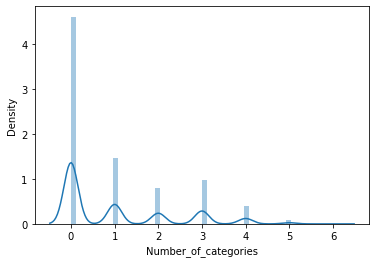

In [30]:
sns.distplot(new_df['Number_of_categories'])

In [31]:
new_df.reset_index(inplace=True)

In [32]:
new_df.drop(columns='index',inplace=True)

# Cleaning the data


In [33]:
new_df['comment_text']

0        Hey man, I'm really not trying to edit war. It...
1        You, sir, are my hero. Any chance you remember...
2             COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
3        Hey... what is it..\n@ | talk .\nWhat is it......
4        Oh, and the girl above started her arguments w...
                               ...                        
36220    I'll be on IRC, too, if you have a more specif...
36221    Image:Barack-obama-mother.jpg listed for delet...
36222    "Editing of article without Consensus & Remova...
36223    "\nNo he did not, read it again (I would have ...
36224    ":::::And for the second time of asking, when ...
Name: comment_text, Length: 36225, dtype: object

In [34]:
def clean_text(text):
   
    # Convert text to all lowercase letters
    text = text.lower()
    
    # Remove whitespaces
    text = text.strip()
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove all tokens that are not alphabetic   r[A-Za-z#]
    tokens = [token for token in tokens if token.isalpha()]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords_list]
    
    # Remove tokens less than three letters
    tokens = [token for token in tokens if not len(token)<3]
    
    # Remove punctuations
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Lemmetize tokens
    tokens = [lemmatizer.lemmatize(token,pos='n') for token in tokens]
    
    # Stem tokens
    #tokens = 
    
    # Re-create text from filtered tokens, so that vectorizer won't complain
    text = ' '.join(tokens)
    return text

In [35]:
clean_df = new_df.copy()

In [36]:
clean_df['comment_text'] = clean_df['comment_text'].apply(lambda x: clean_text(x))

In [37]:
clean_df.comment_text

0        hey man really trying edit war guy constantly ...
1                            sir hero chance remember page
2                              cocksucker piss around work
3        hey talk exclusive group taliban good destroyi...
4        girl started argument stuck nose belong believ...
                               ...                        
36220                                 irc specific request
36221    image listed deletion image medium file upload...
36222    editing article without consensus removal cite...
36223    read would thought everyone could recite heart...
36224    second time asking view completely contradicts...
Name: comment_text, Length: 36225, dtype: object

In [38]:
max([len(x.split()) for x in new_df['comment_text']])

1411

In [39]:
max([len(x.split()) for x in clean_df['comment_text']])

1250

In [40]:
clean_df['word_count'] = clean_df.comment_text.apply(lambda x: (len(x.split())))

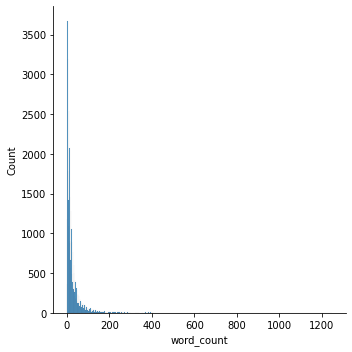

In [41]:
sns.displot(clean_df.word_count)

(0.0, 600.0)

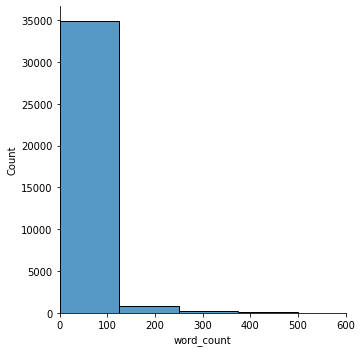

In [42]:
sns.displot(clean_df.word_count,bins=10)
plt.xlim((0,600))

In [43]:
clean_df.comment_text[clean_df.word_count > 600]

548      fuck useless bot fuck useless bot fuck useless...
1098     fuck bastard yyou life fuck bastard yank cock ...
1528     sex sex sex sex sex sex sex sexsex sex sex sex...
2008     ball ball ball ball ball ball ball ball ball b...
2591     thanks watching wiki raid thread ruining fun d...
3003     nigger nigger nigger nigger nigger nigger nigg...
5010     fuck nigga fuck nigga fuck nigga fuck nigga fu...
6095     damn cunt damn cunt damn cunt damn cunt damn c...
6502     jim wale must die jim wale must die jim wale m...
7303     pig pig pig pig pig pig pig pig pig pig pig pi...
7364     really milleseconds wasnt bitch fat jew fat je...
7823     suck suck suck suck suck suck suck suck suck s...
8680     bark bark bark bark bark bark bark bark bark b...
9017     jforget fuck faggot gay as chink nigger cocksu...
9578     wanker wanker wanker wanker wanker wanker wank...
10517    heil hitler heil hitler heil hitler heil hitle...
10597    hahahahahahahahahahahahahahahahahaha vandalism.

It looks like the comments with more than 600 words are usually repititive.


In [44]:
clean_df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Number_of_categories,word_count
0,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,21
1,sir hero chance remember page,0,0,0,0,0,0,0,5
2,cocksucker piss around work,1,1,1,0,1,0,4,4
3,hey talk exclusive group taliban good destroyi...,1,0,0,0,0,0,1,22
4,girl started argument stuck nose belong believ...,0,0,0,0,0,0,0,15
...,...,...,...,...,...,...,...,...,...
36220,irc specific request,0,0,0,0,0,0,0,3
36221,image listed deletion image medium file upload...,0,0,0,0,0,0,0,26
36222,editing article without consensus removal cite...,0,0,0,0,0,0,0,145
36223,read would thought everyone could recite heart...,0,0,0,0,0,0,0,88


In [45]:
clean_df['nothing_bad'] = 0

In [46]:
clean_df['nothing_bad'] = clean_df.apply(lambda x: 1 if x.Number_of_categories == 0 else 0, axis=1)

In [47]:
x_train = clean_df['comment_text'].copy()

In [48]:
y_train = clean_df.iloc[:,[1,2,3,4,5,6,9]]

Lets truncate/pad each sequence/comments to 300 words. This decision is made from two points:
1.  Most of the sequences with words more than 600 have repititive words
2. An assumption that commentator expresses his context (toxic, obscene etc) in the first 300 sentences.

#Tokenizer Embedding

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(x_train)

In [50]:
total_words = len(tk.word_index)

print('Total number of words:', total_words)

Total number of words: 56815


In [51]:
x_train

0        hey man really trying edit war guy constantly ...
1                            sir hero chance remember page
2                              cocksucker piss around work
3        hey talk exclusive group taliban good destroyi...
4        girl started argument stuck nose belong believ...
                               ...                        
36220                                 irc specific request
36221    image listed deletion image medium file upload...
36222    editing article without consensus removal cite...
36223    read would thought everyone could recite heart...
36224    second time asking view completely contradicts...
Name: comment_text, Length: 36225, dtype: object

#Count Vectorizer Embedding

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

# # Training set
X_train_cv = cv.fit_transform(x_train)

In [53]:
len(cv.vocabulary_)

56812

#CBOW Embedding


In [54]:

from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(x_train)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in x_train]

vocab_size = len(word2id)
embed_size = 300
window_size = 2 # context window size

In [55]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 300)            17044800  
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 56816)             17101616  
Total params: 34,146,416
Trainable params: 34,146,416
Non-trainable params: 0
_________________________________________________________________
None


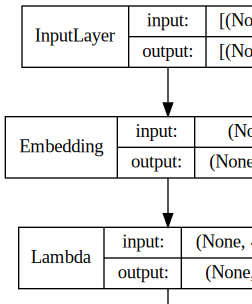

In [56]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()